In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [9]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [10]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [11]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-06-22,41187.05,35601.66,38944.07,18014.22,7.080814e+08,40100.92
2021-06-23,42823.85,38942.78,40100.92,15406.00,6.402227e+08,41312.07
2021-06-24,43435.29,39676.06,41312.07,9691.27,4.025542e+08,42570.68
2021-06-25,43837.53,38360.02,42570.68,9142.30,3.748821e+08,38704.98
2021-06-26,40240.10,36974.93,38704.98,8290.56,3.201060e+08,39558.80


In [12]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-10-31,28379.43,27665.00,28086.61,85.17,2382818.49,27905.41
2022-11-01,28011.26,27636.31,27905.41,66.73,1858719.42,27900.27
2022-11-02,28158.91,27471.28,27900.27,120.48,3350771.68,27589.06
2022-11-03,27946.83,27564.24,27589.06,79.68,2214181.49,27756.61
2022-11-04,27857.46,27726.46,27756.61,11.35,315842.36,27813.37


In [13]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [14]:
train, test = train_test_split(hist, test_size=0.2)

In [15]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-07-28,30972.97,29170.58,29461.68,94.66,2839251.17,30560.96
2022-07-29,31143.54,30157.24,30560.96,86.41,2647395.67,30461.25
2022-07-30,31490.78,30171.65,30461.25,72.19,2236589.25,30301.71
2022-07-31,30868.90,29878.50,30301.71,53.63,1632164.27,30118.05
2022-08-01,30215.06,29385.24,30118.05,45.44,1353898.21,29924.55
...,...,...,...,...,...,...
2022-10-31,28379.43,27665.00,28086.61,85.17,2382818.49,27905.41
2022-11-01,28011.26,27636.31,27905.41,66.73,1858719.42,27900.27
2022-11-02,28158.91,27471.28,27900.27,120.48,3350771.68,27589.06


In [16]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

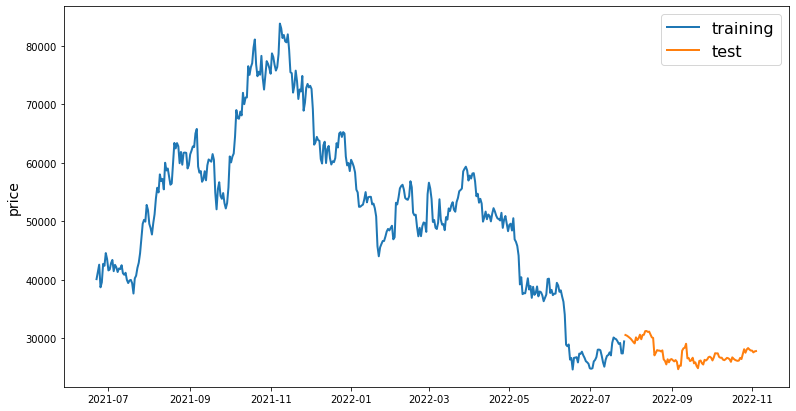

In [17]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [18]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [19]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [20]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [21]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [22]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [23]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [24]:
X_test

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.50705987e-03,  3.38238047e-02,  3.73121967e-02,
         -8.71540249e-02, -6.75725706e-02, -3.26265929e-03],
        [ 1.67181255e-02,  3.43177955e-02,  3.39278005e-02,
         -2.37375872e-01, -2.12260869e-01, -8.48304504e-03],
        [-3.36002650e-03,  2.42682867e-02,  2.85126306e-02,
         -4.33446017e-01, -4.25142697e-01, -1.44926730e-02],
        [-2.44700460e-02,  7.35878409e-03,  2.22787703e-02,
         -5.19966195e-01, -5.23149546e-01, -2.08242804e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.11496638e-02,  4.77828873e-04, -3.26265929e-03,
         -1.64564287e-01, -1.55173790e-01, -5.23747384e-03],
        [-8.81852224e-03, -9.24288827e-03, -8.48304504e-03,
         -3.79354241e-01, -3.83483063e-01, -1.12667734e-02],
        [-2.98129243e-02, -2.5

In [25]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
13/13 [==============================] - 2s 33ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 8/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 9/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 10/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 11/50
13/13 

In [26]:
model.save('mymodel.h5',history)

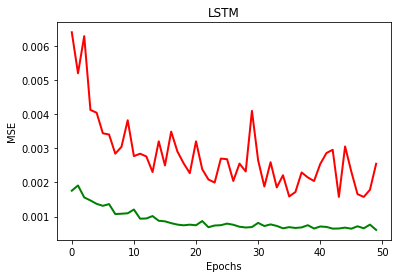

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [28]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 3ms/step


0.01695492626590826

In [29]:
X_test.shape

(95, 5, 6)

In [30]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0006101898787612001

In [31]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7278959485275956

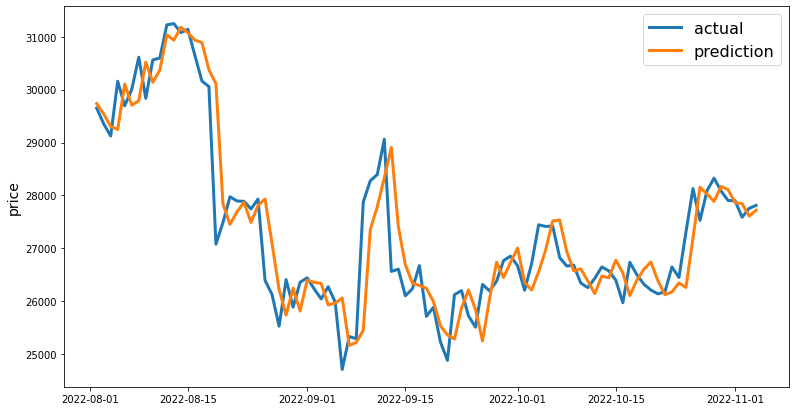

In [32]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)